## CNN - Face to Age

### 1.1 Visualizing images

**Loading the dataset**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("images.csv")
data = data.sample(frac=1, random_state=0).reset_index(drop=True)
data.head(10)

,age,pixels
0,45,200 168 96 107 123 132 132 135 135 134 134 137...
1,1,223 226 231 234 236 238 238 240 240 240 240 23...
2,35,23 29 24 29 47 71 110 141 166 169 169 174 179 ...
3,28,9 6 11 12 30 65 82 37 47 16 27 26 32 74 141 16...
4,24,67 66 63 59 61 62 60 66 83 103 139 173 192 194...
5,30,67 79 118 140 142 142 133 147 188 208 194 201 ...
6,4,16 18 15 9 8 11 6 7 10 8 9 14 13 12 16 21 21 1...
7,32,47 46 36 30 34 29 17 19 33 45 56 48 53 64 52 5...
8,51,237 239 237 214 114 69 85 205 172 67 60 127 14...
9,30,49 48 46 53 57 54 58 62 69 73 79 79 78 69 77 9...


Each row represent the image of a face in black and white
- `age` is the age in year
- `pixels` contains the 2304 (= 48 * 48) flatten values of each pixel in the image, in a black scale from 0 to 255, stored as string

**The histogram of age in the dataset.**

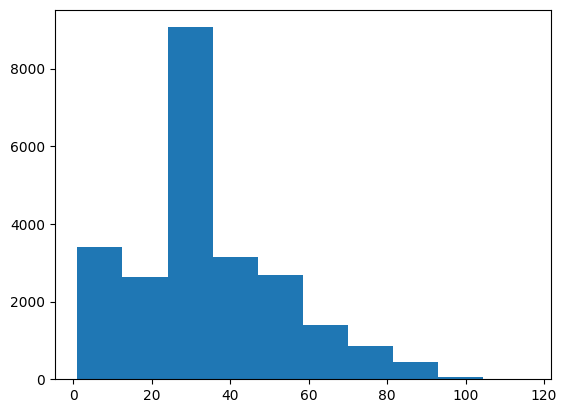

In [3]:
plt.hist(data['age']);

**Number of images**

In [4]:
print(f"In this dataset, we have {data.shape[0]} images")

In this dataset, we have 23705 images


**Visually display one random image**

This person's age is: 76


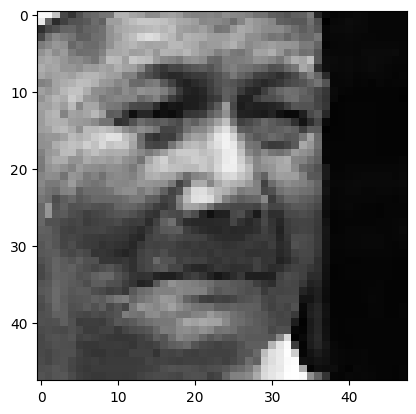

In [5]:
img = data.pixels[260]
img = list(map(int, img.split()))
img = np.array(img).reshape(48, 48)

plt.imshow(img, cmap='gray')
print(f"This person's age is: {data.age[260]}")
plt.show();

**Visually display another image**


This person's age is: 27


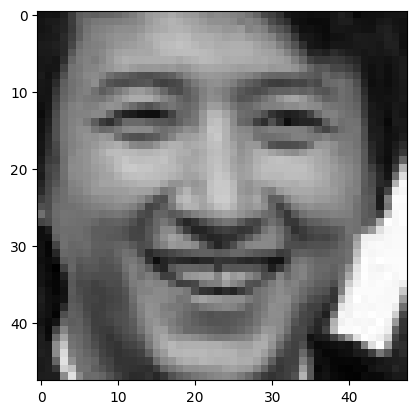

In [6]:
img = data.pixels[60]
img = list(map(int, img.split()))
img = np.array(img).reshape(48, 48)

plt.imshow(img, cmap='gray')
print(f"This person's age is: {data.age[60]}")
plt.show();

### 1.2 Processing

- We create the **feature matrix** `X` as `ndarray` scaled between 0 and 1
- We create the **target vector** `y` as `ndarray`
- Then we create the holdout sets: 4 variables (`X_train`, `y_train`) and (`X_test`, `y_test`) keeping the **first** `70%` as the train set

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims

#Setting X
list_img = []
for i in range(data.shape[0]):
    img = data["pixels"][i]
    img = list(map(float, img.split()))
    img = np.array(img)/255
    img = img.reshape(48, 48)
    list_img.append(img)   
X = np.array(list_img)

#Setting y
y = np.array(data['age'])

#check type and shape
print(type(X), X.shape)
print(type(y), y.shape)

#creating train and test holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#add a dimension to fit a CNN:
X_train = expand_dims(X_train, axis=-1)
X_test = expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)

<class 'numpy.ndarray'> (23705, 48, 48)
<class 'numpy.ndarray'> (23705,)
(16593, 48, 48, 1)
(7112, 48, 48, 1)


### 1.3 Modeling the age of a face

❓ **Evaluating the baseline score**
(we always predict mean age)

In [13]:
err = np.absolute(y - y.mean())
score_baseline = err.mean()
score_baseline

15.34814871735347

**Building and fitting a convolutional neural network**

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

def initialize_model():
    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(48, 48, 1), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Prevent overfitting
    model.add(layers.Dropout(rate=0.2)) 
    
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))

    ### Prevent overfitting
    model.add(layers.Dropout(rate=0.2))
    
    ### Last layer - Regression task with one output
    model.add(layers.Dense(1, activation='linear'))
    
    ### Model compilation
    model.compile(loss='mse',
                  optimizer='adam', 
                  metrics=['mae'])
    
    return model

model = initialize_model()
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 200,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/200
363/363 [==============================] - 11s 28ms/step - loss: 566.1052 - mae: 18.4486 - val_loss: 411.0345 - val_mae: 14.9589
Epoch 2/200
363/363 [==============================] - 10s 28ms/step - loss: 456.9772 - mae: 16.5782 - val_loss: 341.8593 - val_mae: 14.5083
Epoch 3/200
363/363 [==============================] - 11s 29ms/step - loss: 409.0967 - mae: 15.7012 - val_loss: 281.4431 - val_mae: 12.9540
Epoch 4/200
363/363 [==============================] - 12s 33ms/step - loss: 374.1130 - mae: 14.9607 - val_loss: 257.5630 - val_mae: 12.2613
Epoch 5/200
363/363 [==============================] - 12s 32ms/step - loss: 354.9827 - mae: 14.5111 - val_loss: 241.1732 - val_mae: 12.1510
Epoch 6/200
363/363 [==============================] - 12s 32ms/step - loss: 353.2890 - mae: 14.3907 - val_loss: 236.3353 - val_mae: 11.9580
Epoch 7/200
363/363 [==============================] - 12s 32ms/step - loss: 333.7137 - mae: 13.9951 - val_loss: 251.5050 - val_mae: 11.8452
Epoch 8/200
3

**Plotting the training and validation MAE at each epoch**

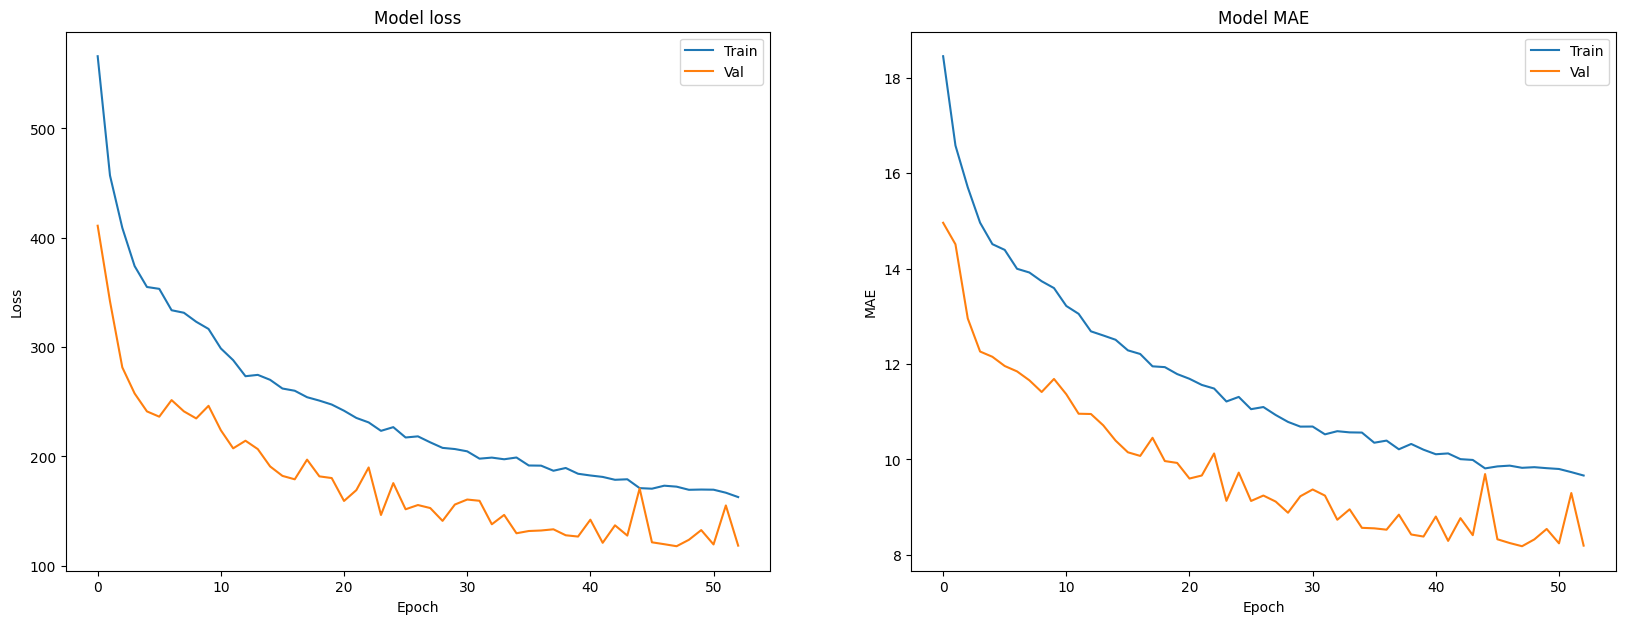

In [22]:
def plot_loss_mae(history):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='best')

    
    # --- MAE
    
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')


plot_loss_mae(history)

**Evaluate the performances on test set**

In [23]:
score_test = model.evaluate(X_test, y_test, verbose = 1)[1]
score_test

223/223 [==============================] - 2s 10ms/step - loss: 116.8417 - mae: 8.0558


8.055764198303223

The score has improved significantly comparing to the baseline.

The final`score_test` means that the model can predict the age of a person with a precision of +/- 8 years